# 目的 #
テーマ（use case）を設定し、そのテーマに合った「顔検出アプリ」を Jupyter Notebook で作る

### テーマ（Use Case）を決める
今回は、スポーツ観戦の混雑度について顔分析を行う。
混雑度を「画像内に写っている人物の密集の程度」とする。正確な観客人数を推定することは目的とせず、顔検出によって得られた人数情報を用いて、混雑の程度を評価することが目的。

---
↓データのインポート、分析、画像解析


In [1]:
%pip install ultralytics dill opencv-python matplotlib facenet-pytorch mtcnn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


検出された顔の数: 300 faces


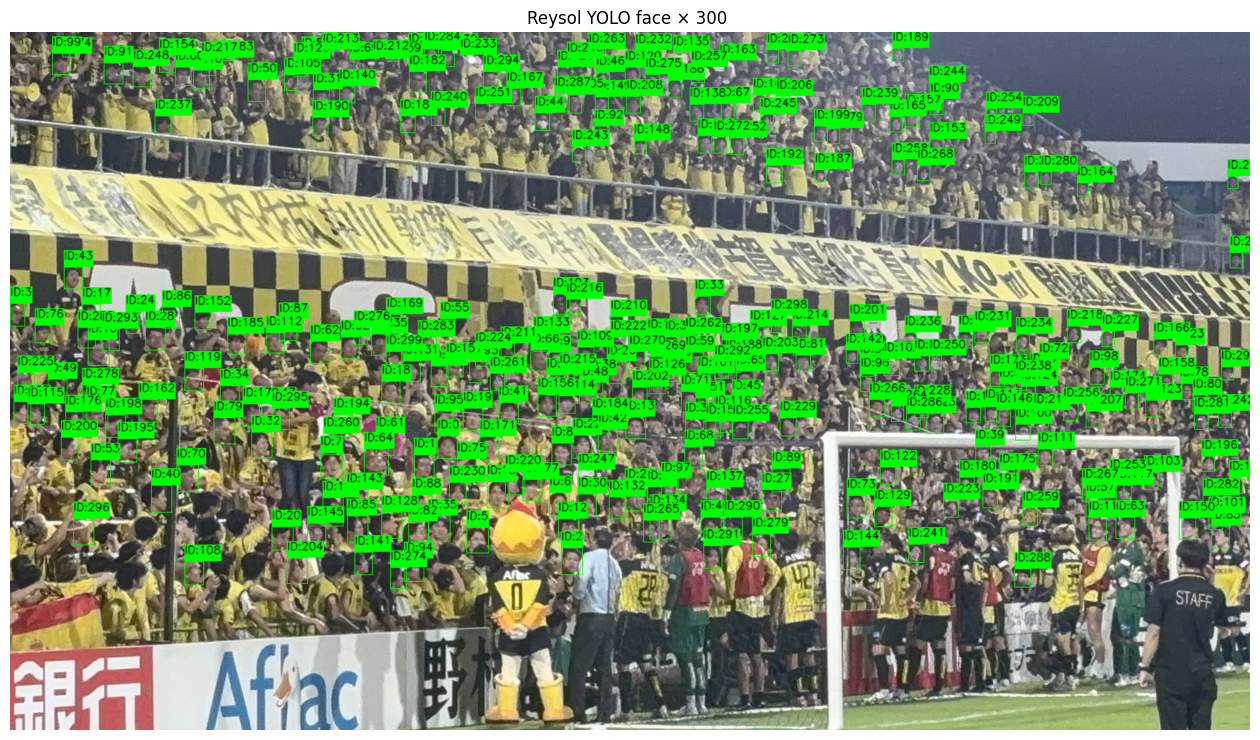

In [3]:
import cv2
from pathlib import Path
from ultralytics import YOLO
import matplotlib.pyplot as plt

# 画像とモデルの準備
image_path = Path("S__207560734.jpg")
model_path = Path("yolov8m-face.pt")

# YOLO で高解像度推論（imgsz を指定）
model = YOLO(model_path)
result = model.predict(source=str(image_path), conf=0.25, verbose=False, imgsz=1280)[0]

# 画像読み込みと基本情報
annotated = cv2.imread(str(image_path))
h_img, w_img = annotated.shape[:2]
color = (0,255,0)
font_scale = 0.5
thickness = 1

# 検出結果を描画（バッファ付き）
for idx, box in enumerate(result.boxes.xyxy.cpu().numpy()):
    x1,y1,x2,y2 = map(int, box)
    w = x2 - x1; h = y2 - y1
    pad = int(max(w,h) * 0.2)  # バッファ 20%
    x1p = max(0, x1 - pad); y1p = max(0, y1 - pad)
    x2p = min(w_img, x2 + pad); y2p = min(h_img, y2 + pad)
    cv2.rectangle(annotated, (x1p,y1p), (x2p,y2p), color, thickness)
    label = f"ID:{idx}"
    (w_label, h_label), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
    y_label = y1p-6 if y1p-6>h_label else y1p+h_label+6
    cv2.rectangle(annotated, (x1p, y_label-h_label-baseline), (x1p+w_label, y_label+baseline), color, -1)
    cv2.putText(annotated, label, (x1p, y_label-baseline), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0,0,0), thickness, cv2.LINE_AA)

# 高解像度で保存（アップスケールして保存）
output_path = Path("reysol_yolo_faces.jpg")
annot_up = cv2.resize(annotated, (w_img*2, h_img*2), interpolation=cv2.INTER_CUBIC)
cv2.imwrite(str(output_path), annot_up)
print(f"検出された顔の数: {len(result.boxes)} faces")
plt.figure(figsize=(16,16))
plt.imshow(cv2.cvtColor(annot_up, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f'Reysol YOLO face × {len(result.boxes)} ')
plt.show()

### 何を検出したかを把握する

コラージュを保存しました: S__207560734_faces_collage.jpg (faces: 300)


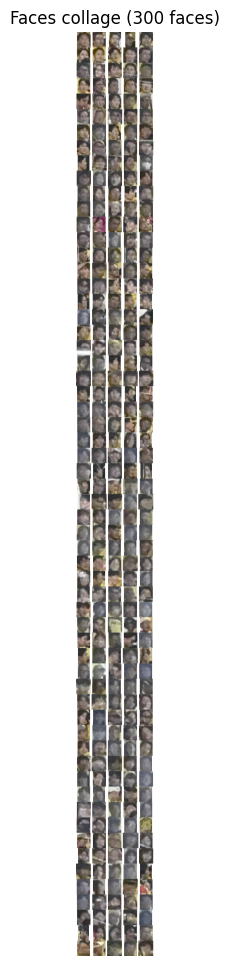

In [4]:
import cv2
import numpy as np
from math import ceil
from pathlib import Path
import matplotlib.pyplot as plt

def collage_faces(image_path):
    """
    collage_faces(image_path): YOLO で検出して顔を切り出し、コラージュを作成する関数。
    引数は image_path のみ（文字列または Path）。
    """
    image_path = Path(image_path)
    model_path = Path('yolov8m-face.pt')
    from ultralytics import YOLO
    model = YOLO(model_path)
    result = model.predict(source=str(image_path), conf=0.25, verbose=False, imgsz=1280)[0]

    img = cv2.imread(str(image_path))
    if img is None:
        raise FileNotFoundError(f'Image not found: {image_path}')
    h_img, w_img = img.shape[:2]
    faces = []
    tile = 256

    for box in result.boxes.xyxy.cpu().numpy():
        x1, y1, x2, y2 = map(int, box)
        w = x2 - x1; h = y2 - y1
        pad = int(max(w, h) * 0.2)
        x1p = max(0, x1 - pad); y1p = max(0, y1 - pad)
        x2p = min(w_img, x2 + pad); y2p = min(h_img, y2 + pad)
        if x2p <= x1p or y2p <= y1p:
            continue
        crop = img[y1p:y2p, x1p:x2p]
        h_c, w_c = crop.shape[:2]
        size = max(h_c, w_c)
        square = np.full((size, size, 3), 255, dtype=np.uint8)
        y_off = (size - h_c)//2; x_off = (size - w_c)//2
        square[y_off:y_off+h_c, x_off:x_off+w_c] = crop
        faces.append(cv2.resize(square, (tile, tile), interpolation=cv2.INTER_AREA))

    if len(faces) == 0:
        print('コラージュ用の顔が見つかりません')
        return None

    cols = min(5, len(faces))
    rows = ceil(len(faces) / cols)
    canvas = np.full((rows*tile, cols*tile, 3), 255, dtype=np.uint8)
    for idx, f in enumerate(faces):
        r = idx // cols; c = idx % cols
        canvas[r*tile:(r+1)*tile, c*tile:(c+1)*tile] = f

    output_path = image_path.with_name(image_path.stem + '_faces_collage.jpg')
    cv2.imwrite(str(output_path), canvas)
    print(f'コラージュを保存しました: {output_path} (faces: {len(faces)})')
    plt.figure(figsize=(16,12))
    plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Faces collage ({len(faces)} faces)')
    plt.show()

collage_faces('S__207560734.jpg')

### 分析結果
スポーツ観戦写真では、多数の顔が検出され、観客が密集している様子が確認できたこと、非常に検出された人が多くその感覚も近いことから密度が高いことがわかる。そのため、この写真は「非常に混雑している」状態であると判断できる。しかし、検出されたものを見ると顔ではないものが認識されていることがわかるため正確性には欠けると感じた。

### Yoloの所感

**Yoloの強み**

１，多人数・高密度環境でも一括検出できる。観客が非常に多く、顔が小さく密集しているこの写真でも数百人規模の顔を一度に検出できていることから混雑したシーンの「人数感」把握には非常に強いと思った。

２，小さい顔もある程度検出できる。観客席上部の 非常に小さい顔も多数検出されていることから小さい顔でも認識できるものであれば検出できる。

**Yoloの弱み**

１，後頭部・横顔は検出できない。観客の多くはピッチを向いていたり、後頭部・横顔が多いため正確に顔の検出が難しい。そのため。検出されないものがあり、実際の人数より 少なく検出される。

２，遠距離の極小顔は検出漏れが起きる。最上段の観客では、顔が数ピクセル程度人の頭なのに検出されないケースがある。
さっきある程度の検出はできると書いたが、小さすぎて顔として認識されないものもあった。

３，誤検出（顔でない部分）も混ざる可能性がある。今回の写真は、黄色い服・模様・旗などが多く、顔っぽいパターン明暗の強い部分を誤って検出する可能性がある。分析結果からも誤検出をしたものがあったため、正確性には欠けると思う。



### もっと検出されやすくするには？ ###
画像を大きくしたり、confを下げてみた

WARNING imgsz=[1960] must be multiple of max stride 32, updating to [1984]
検出された顔の数: 300 faces


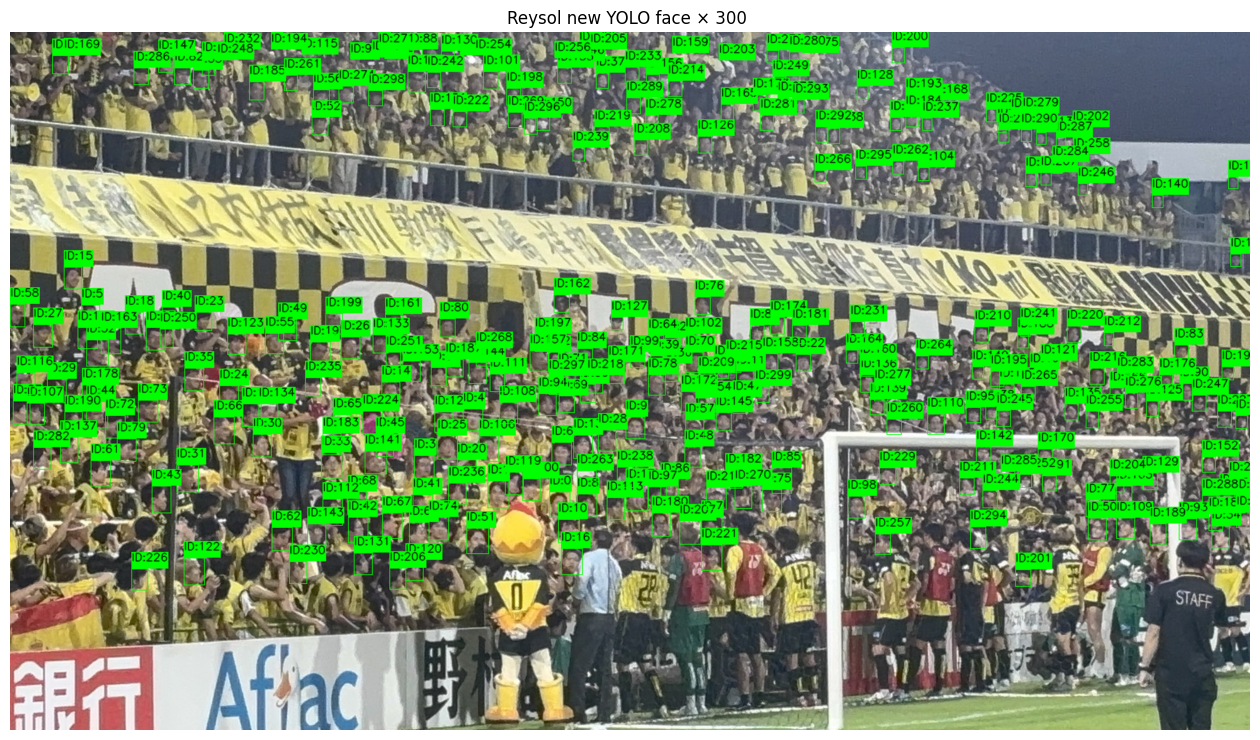

In [5]:
import cv2
from pathlib import Path
from ultralytics import YOLO
import matplotlib.pyplot as plt

# 画像とモデルの準備
image_path = Path("S__207560734.jpg")
model_path = Path("yolov8m-face.pt")

# YOLO で高解像度推論（imgsz を指定）
model = YOLO(model_path)
result = model.predict(source=str(image_path), conf=0.05, verbose=False, imgsz=1960)[0]

# 画像読み込みと基本情報
annotated = cv2.imread(str(image_path))
h_img, w_img = annotated.shape[:2]
color = (0,255,0)
font_scale = 0.5
thickness = 1

# 検出結果を描画（バッファ付き）
for idx, box in enumerate(result.boxes.xyxy.cpu().numpy()):
    x1,y1,x2,y2 = map(int, box)
    w = x2 - x1; h = y2 - y1
    pad = int(max(w,h) * 0.2)  # バッファ 20%
    x1p = max(0, x1 - pad); y1p = max(0, y1 - pad)
    x2p = min(w_img, x2 + pad); y2p = min(h_img, y2 + pad)
    cv2.rectangle(annotated, (x1p,y1p), (x2p,y2p), color, thickness)
    label = f"ID:{idx}"
    (w_label, h_label), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
    y_label = y1p-6 if y1p-6>h_label else y1p+h_label+6
    cv2.rectangle(annotated, (x1p, y_label-h_label-baseline), (x1p+w_label, y_label+baseline), color, -1)
    cv2.putText(annotated, label, (x1p, y_label-baseline), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0,0,0), thickness, cv2.LINE_AA)

# 高解像度で保存（アップスケールして保存）
output_path = Path("reysol new_yolo_faces.jpg")
annot_up = cv2.resize(annotated, (w_img*2, h_img*2), interpolation=cv2.INTER_CUBIC)
cv2.imwrite(str(output_path), annot_up)
print(f"検出された顔の数: {len(result.boxes)} faces")
plt.figure(figsize=(16,16))
plt.imshow(cv2.cvtColor(annot_up, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f'Reysol new YOLO face × {len(result.boxes)} ')
plt.show()

結果としてもあたいが変わんなかった。調べてみたらYOLOはCNNベースなので、目、鼻、輪郭といった特徴量がある程度のピクセル数で存在しないと検出できないため、
今回の写真では、上段の観客の顔が数ピクセルであったり、目・鼻が潰れて 単色の点に近い
conf を下げても、そもそも「顔だと判断できる情報」がない
だからconf を 0.25 → 0.1imgsz を 1280 → 1920にしても検出数が増えないと考えられる